In [971]:
import pandas as pd
import numpy as np

### Importing and processing the data for analysis

In [972]:
data = pd.read_excel('Datasheet - Conversions - Data Analysis.xlsx')

In [973]:
data.head()

,Customer ID,Registration Date,Source,First Purchase Date,Date Second Purchase,Last Purchase,Total Orders
0,3024.0,2019-11-07,Email,NaN,NaT,NaN,NaN
1,3040.0,2019-11-10,Email,NaN,NaT,NaN,NaN
2,3041.0,2019-11-10,Email,NaN,NaT,NaN,NaN
3,3042.0,2019-11-10,Email,NaN,NaT,NaN,NaN
4,3049.0,2019-11-12,Email,NaN,NaT,NaN,NaN


### Checking data types for consistency

In [974]:
data.dtypes

Customer ID                    float64
Registration Date       datetime64[ns]
Source                          object
First Purchase Date             object
Date Second Purchase    datetime64[ns]
Last Purchase                   object
Total Orders                   float64
dtype: object

Changing the dtypes to relevant formats

In [ ]:
## remove weird missing entry
data['Last Purchase'].loc[2286] = np.nan

In [976]:
data['Source'] = data['Source'].astype('str')
data['First Purchase Date'] = data['First Purchase Date'].astype('datetime64[ns]')
data['Last Purchase'] = data['Last Purchase'].astype('datetime64[ns]')

In [977]:
data.head()

,Customer ID,Registration Date,Source,First Purchase Date,Date Second Purchase,Last Purchase,Total Orders
0,3024.0,2019-11-07,Email,NaT,NaT,NaT,NaN
1,3040.0,2019-11-10,Email,NaT,NaT,NaT,NaN
2,3041.0,2019-11-10,Email,NaT,NaT,NaT,NaN
3,3042.0,2019-11-10,Email,NaT,NaT,NaT,NaN
4,3049.0,2019-11-12,Email,NaT,NaT,NaT,NaN


### Analysis of different cohorts

##### Total order averages over the entire year

In [978]:
## copying the original data for manipulation (remove missing data)
data_mean = data.copy(deep=True)
data_mean = data_mean.dropna()

## calculating the table of average total orders for each source
data_mean_show = data_mean[['Total Orders', 'Source']].groupby('Source').mean()
data_mean_show = data_mean_show.rename(columns={'Total Orders': 'Average Total Orders'})
data_mean_show

,Average Total Orders
Source,
Email,4.677419
Facebook,4.478070
Google / Other Search,3.883333
Instagram,3.352941
Pinterest,2.000000
Referral,4.554054
nan,5.200000


<Axes: xlabel='Source'>

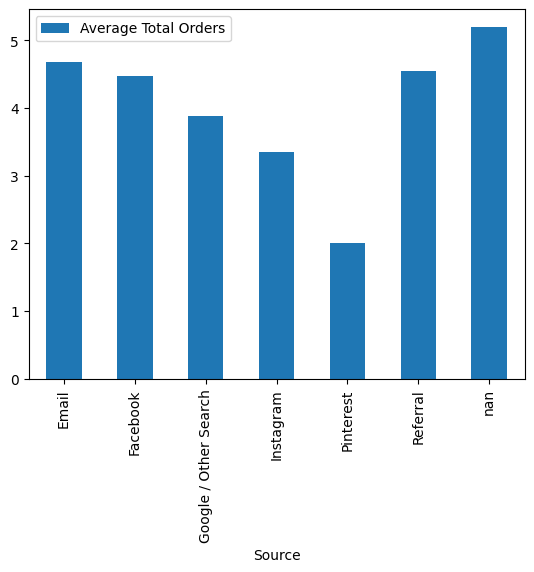

In [979]:
data_mean_show.plot.bar()

From the table above, we can see that from all the channels, Email, Referral, and Facebook drive the most sales (and possibly traffic/conversion). This may be due to the nature of the wholesale market where the demand side is composed of retail businesses or similar, whose employees and owners usually operate in these spaces. Interesting observation is Instagram and Pinterest, which could signify other cohorts within the demand side, such as consumers.

Further data on traffic from source, click-through rates and user journey from channel to website would be nice, as it would allow me to know more about how these channels bring in customers and what the customers are like. This will all contribute to tailoring the product/user experience to the customers.

Note that we have removed a lot of missing data from the sample. However, since we are dealing with averages, and the sample size is still greater than 30 and 50, the law of large numbers should apply and the averages calculate above should be close to the true value

##### Conversion contribution from each source

In [980]:
data_mean_conv = data_mean[['Source', 'First Purchase Date']]
data_mean_conv = data_mean_conv.groupby(data_mean_conv['Source']).agg({'count'})
data_mean_conv

,First Purchase Date
,count
Source,
Email,31
Facebook,228
Google / Other Search,180
Instagram,51
Pinterest,1
Referral,74
nan,70


<Axes: xlabel='Source'>

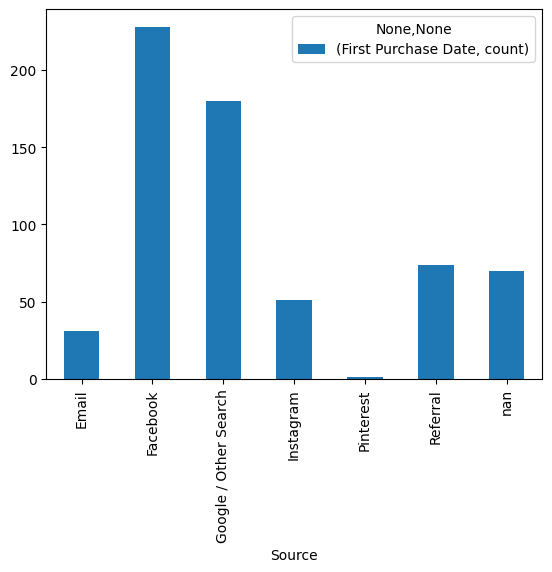

In [981]:
data_mean_conv.plot.bar()

However, once we take a further look at the actual conversions, we can see that Facebook and search results drive the most registration-to-first-purchase conversions.

The lack of conversions from referrals is interesting, despite it being one of the top three channels contributing to total purchase orders. This could suggest that the average ticket size for referred customers is higher than other sources.

##### Breaking down the total order frequency for each month

creating a melted dataframe to stack all purchase occurrences

In [982]:
data_month = data[['Customer ID', 'First Purchase Date', 'Date Second Purchase', 'Last Purchase']].copy(deep=True)

data_month = data_month.rename(columns={'First Purchase Date': 'purchase.1',
                           'Date Second Purchase': 'purchase.2',
                           'Last Purchase': 'purchase.3'})

data_month = data_month.melt('Customer ID', value_name='purchase')

data_month = data_month.drop(columns='variable')

data_month = data_month.set_index('Customer ID')

aggregating the data by year and month

In [983]:
data_month = data_month.groupby([data_month['purchase'].dt.year.rename('year'), data_month['purchase'].dt.month.rename('month')]).agg({'count'})
data_month = data_month.drop(index=1970)
data_month

purchase
                count
year   month         
2020.0 1.0         21
       2.0         43
       3.0         18
       4.0         58
       5.0        112
       6.0        195
       7.0        204
       8.0        218
       9.0        249
       10.0       270
       11.0       311
       12.0       114
2021.0 1.0        284
       2.0        378
       3.0        393
       4.0        255

visualizing the trend

<Axes: title={'center': 'Purchases over time in 2020'}, xlabel='month', ylabel='No. of purchases'>

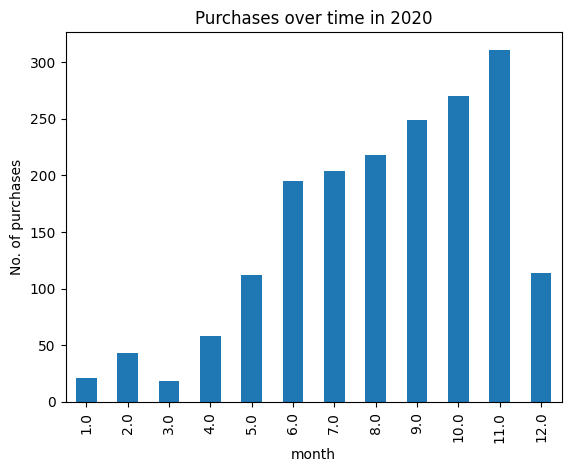

In [984]:
data_month.loc[2020].plot.bar(ylabel='No. of purchases', legend=False, title='Purchases over time in 2020')

<Axes: title={'center': 'Purchases over time in 2021'}, xlabel='month', ylabel='No. of purchases'>

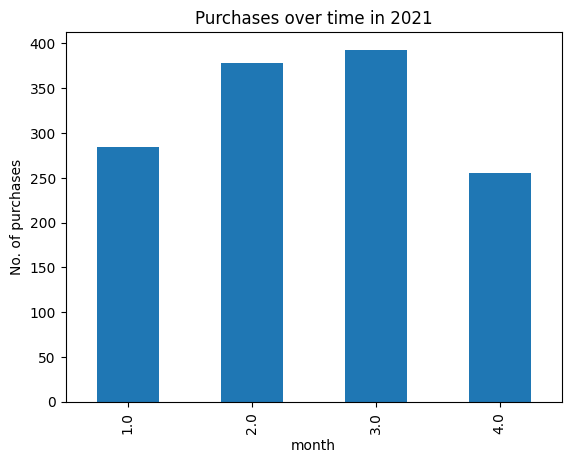

In [985]:
data_month.loc[2021].plot.bar(ylabel='No. of purchases', legend=False, title='Purchases over time in 2021')

Here, you can see that user purchase numbers fluctuate over the course of the year, suggesting some kind of seasonality. A more plausible reasoning is that the wholesale market is not a high frequency marketplace (think Uber, Deliveroo, etc), but a low frequency marketplace (think Healthcare, Insurance, etc.). This means that purchasing frequency will be very needs-based and situational. What we can do is to keep them constantly in the loop with direct-to-consumer marketing campaigns to remind them of our existence and cross-sell as much as possible.

data on cross-purchasing behavior would be good for this.

##### Speed of conversion from clicking through

In [986]:
## get in dt.days the difference between data['Registration Date']
## and data['First Purchase Date']

data_ret = data.copy(deep=True)
data_ret_na = data.copy(deep=True)
data_ret = data_ret.dropna()
data_ret = data_ret.reset_index()
data_ret['days_to_purchase'] = (data_ret['First Purchase Date'] - data_ret['Registration Date']).dt.days
data_ret['days_to_purchase_2'] = (data_ret['Date Second Purchase'] - data_ret['First Purchase Date']).dt.days
data_ret['days_to_purchase_3'] = (data_ret['Last Purchase'] - data_ret['Date Second Purchase']).dt.days
data_ret['first_to_last_purchase'] = (data_ret['Last Purchase'] - data_ret['First Purchase Date']).dt.days

data_ret = data_ret[['Customer ID', 'days_to_purchase', 'days_to_purchase_2', 'days_to_purchase_3', 'first_to_last_purchase']]

<Axes: >

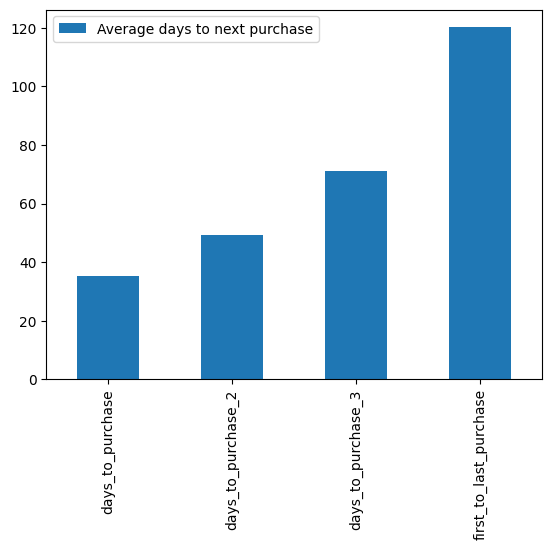

In [987]:
data_ret_mean = pd.DataFrame(data_ret[['days_to_purchase', 'days_to_purchase_2', 'days_to_purchase_3', 'first_to_last_purchase']].mean())

data_ret_mean = data_ret_mean.rename(columns={0: 'Average days to next purchase'})

data_ret_mean.plot.bar()

As you can see from the bar chart above, the average days to purchase is quite substantial: around 38 days from registration to first purchase, almost 50 days from first purchase to second purchase, and around 70 days from second purchase to third purchase. From a broader perspective, it takes around 120 days or almost 4 months for a customer to make 3 purchases on average.

This supports my initial hypothesis that the wholesale market is a low frequency market. Hence, the urge to keep users in the loop through campaigns and acquiring new customers is paramount.

Since we removed a lot of missing data, only 635 entries remain. This may skew our results because of many reasons, such as missing out on customers who conducted less than 3 purchases.

Let us see the results if we did not drop all missing data.

<Axes: >

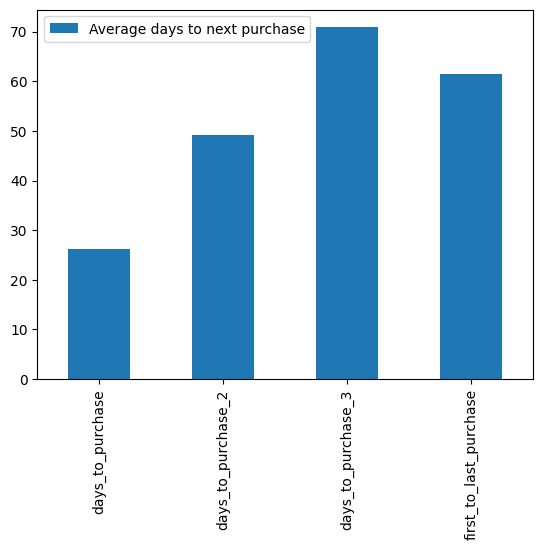

In [988]:
data_ret_null = data_ret_na[data_ret_na.isnull().any(axis=1)]

data_ret_na['days_to_purchase'] = (data_ret_na['First Purchase Date'] - data_ret_na['Registration Date']).dt.days
data_ret_na['days_to_purchase_2'] = (data_ret_na['Date Second Purchase'] - data_ret_na['First Purchase Date']).dt.days
data_ret_na['days_to_purchase_3'] = (data_ret_na['Last Purchase'] - data_ret_na['Date Second Purchase']).dt.days
data_ret_na['first_to_last_purchase'] = (data_ret_na['Last Purchase'] - data_ret_na['First Purchase Date']).dt.days

data_ret_na = data_ret_na[['Customer ID', 'days_to_purchase', 'days_to_purchase_2', 'days_to_purchase_3', 'first_to_last_purchase']]

data_ret_na_mean = pd.DataFrame(data_ret_na[['days_to_purchase', 'days_to_purchase_2', 'days_to_purchase_3', 'first_to_last_purchase']].mean())

data_ret_na_mean = data_ret_na_mean.rename(columns={0: 'Average days to next purchase'})

data_ret_na_mean.plot.bar()


But we could do better; Entries which only have 2 transactions will have a missing second purchase date. Hence, we can push the last purchase date into the second purchase date and account for this.

In [989]:
data_ret_fix = data.copy(deep=True)

data_ret_fix['Date Second Purchase'] = data_ret_fix['Date Second Purchase'].fillna(data_ret_fix['Last Purchase'])

data_ret_fix['days_to_purchase'] = (data_ret_fix['First Purchase Date'] - data_ret_fix['Registration Date']).dt.days
data_ret_fix['days_to_purchase_2'] = (data_ret_fix['Date Second Purchase'] - data_ret_fix['First Purchase Date']).dt.days
data_ret_fix['days_to_purchase_3'] = (data_ret_fix['Last Purchase'] - data_ret_fix['Date Second Purchase']).dt.days
data_ret_fix['first_to_last_purchase'] = (data_ret_fix['Last Purchase'] - data_ret_fix['First Purchase Date']).dt.days

<Axes: >

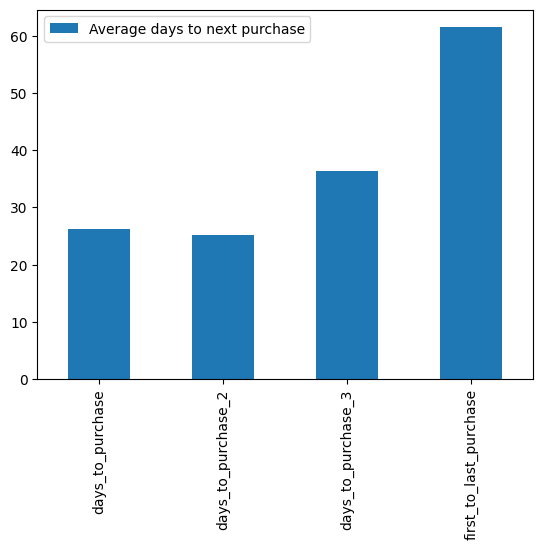

In [990]:
data_ret_fix = data_ret_fix[['Customer ID', 'days_to_purchase', 'days_to_purchase_2', 'days_to_purchase_3', 'first_to_last_purchase']]

data_ret_fix_mean = pd.DataFrame(data_ret_fix[['days_to_purchase', 'days_to_purchase_2', 'days_to_purchase_3', 'first_to_last_purchase']].mean())

data_ret_fix_mean = data_ret_fix_mean.rename(columns={0: 'Average days to next purchase'})

data_ret_fix_mean = data_ret_fix_mean.fillna(0) 

data_ret_fix_mean.plot.bar()

Here, we can see that the figures with missing entries accounted for is not so different from the one with missing entries removed, just with the time between purchases dampened due to 0's within the average. The general insight should be the same.

##### Retention Behavior

In [991]:
data_ret_null.loc[data_ret_null['First Purchase Date'].isnull()]

,Customer ID,Registration Date,Source,First Purchase Date,Date Second Purchase,Last Purchase,Total Orders
0,3024.0,2019-11-07,Email,NaT,NaT,NaT,NaN
1,3040.0,2019-11-10,Email,NaT,NaT,NaT,NaN
2,3041.0,2019-11-10,Email,NaT,NaT,NaT,NaN
3,3042.0,2019-11-10,Email,NaT,NaT,NaT,NaN
4,3049.0,2019-11-12,Email,NaT,NaT,NaT,NaN
...,...,...,...,...,...,...,...
8243,21655.0,2021-02-28,Google / Other Search,NaT,NaT,NaT,NaN
8244,21656.0,2021-02-28,Google / Other Search,NaT,NaT,NaT,NaN
8245,21657.0,2021-02-28,Instagram,NaT,NaT,NaT,NaN
8246,21658.0,2021-02-28,Facebook,NaT,NaT,NaT,NaN


As you can see here, 7011 entries are recorded as not having purchased anything at all despite having registered!

In [992]:
data_ret_null['Date Second Purchase'].loc[data_ret_null['Date Second Purchase'].isnull()]

0      NaT
1      NaT
2      NaT
3      NaT
4      NaT
        ..
8249   NaT
8250   NaT
8251   NaT
8252   NaT
8253   NaT
Name: Date Second Purchase, Length: 7618, dtype: datetime64[ns]

We have an additional ~600 entries who apparently bought items only once. This gives further evidence that we need to investigate retention further.